In [1]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Activation, Conv3D, Dense, Dropout, Flatten, MaxPooling3D
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
squat_3dcnnmodel = Sequential()
squat_3dcnnmodel.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=([32, 32, 30, 3]), border_mode='same'))
squat_3dcnnmodel.add(Activation('relu'))
squat_3dcnnmodel.add(Conv3D(32, kernel_size=(3, 3, 3), border_mode='same'))
squat_3dcnnmodel.add(Activation('softmax'))
squat_3dcnnmodel.add(MaxPooling3D(pool_size=(3, 3, 3), border_mode='same'))
squat_3dcnnmodel.add(Dropout(0.25))

squat_3dcnnmodel.add(Conv3D(64, kernel_size=(3, 3, 3), border_mode='same'))
squat_3dcnnmodel.add(Activation('relu'))
squat_3dcnnmodel.add(Conv3D(64, kernel_size=(3, 3, 3), border_mode='same'))
squat_3dcnnmodel.add(Activation('softmax'))
squat_3dcnnmodel.add(MaxPooling3D(pool_size=(3, 3, 3), border_mode='same'))
squat_3dcnnmodel.add(Dropout(0.25))

squat_3dcnnmodel.add(Flatten())
squat_3dcnnmodel.add(Dense(512, activation='sigmoid'))
squat_3dcnnmodel.add(Dropout(0.5))
squat_3dcnnmodel.add(Dense(2, activation='softmax'))

c:\users\dnly\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, kernel_size=(3, 3, 3), input_shape=[32, 32, 3..., padding="same")`
  
c:\users\dnly\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(32, kernel_size=(3, 3, 3), padding="same")`
  after removing the cwd from sys.path.
c:\users\dnly\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(3, 3, 3), padding="same")`
  
c:\users\dnly\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv3D` call to the Keras 2 API: `Conv3D(64, kernel_size=(3, 3, 3), padding="same")`
  if __name__ == '__main__':
c:\users\dnly\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:11: UserWarning:

In [3]:
squat_3dcnnmodel.load_weights("3dcnnresults/squat_3dcnnmodel.hd5")
squat_3dcnnmodel.trainable = False

In [4]:
squat_3dcnnmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 32, 32, 30, 32)    2624      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 30, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 30, 32)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 30, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 11, 11, 10, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 10, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 11, 11, 10, 64)    55360     
__________

In [5]:
import numpy as np
import cv2


class Videoto3D:

    def __init__(self, width, height, depth):
        self.width = width
        self.height = height
        self.depth = depth

    def video3d(self, filename, color=False, skip=True):
        cap = cv2.VideoCapture(filename)
        nframe = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        if skip:
            frames = [x * nframe / self.depth for x in range(self.depth)]
        else:
            frames = [x for x in range(self.depth)]
        framearray = []

        for i in range(self.depth):
            cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
            ret, frame = cap.read()
            frame = cv2.resize(frame, (self.height, self.width))
            if color:
                framearray.append(frame)
            else:
                framearray.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        cap.release()
        return np.array(framearray)



    def get_UCF_classname(self, filename):
        return filename[filename.find('_') + 1:filename.find('_', 2)]

In [6]:
def loaddata(video_dir, vid3d, nclass, result_dir, color=False, skip=True):
    files = os.listdir(video_dir)
    X = []
    labels = []
    labellist = []

    pbar = tqdm(total=len(files))

    for filename in files:
        pbar.update(1)
        if filename == '.DS_Store':
            continue
        name = os.path.join(video_dir, filename)
        label = vid3d.get_classname(filename)
        if label not in labellist:
            if len(labellist) >= nclass:
                continue
            labellist.append(label)
        labels.append(label)
        X.append(vid3d.video3d(name, color=color, skip=skip))

    pbar.close()
    with open(os.path.join(result_dir, 'classes.txt'), 'w') as fp:
        for i in range(len(labellist)):
            fp.write('{}\n'.format(labellist[i]))

    for num, label in enumerate(labellist):
        for i in range(len(labels)):
            if label == labels[i]:
                labels[i] = num
    if color:
        return np.array(X).transpose((0, 2, 3, 4, 1)), labels
    else:
        return np.array(X).transpose((0, 2, 3, 1)), labels


In [8]:
from videoto3d import Videoto3D as vid3d

In [9]:
videos = "new_data//"

img_rows = 32
img_cols = 32
depth = 30

nclass = 2
output = "new_data_results//"
channel = 3
color = True
skip = False

frames = depth
nb_classes = nclass



In [10]:
x, y = loaddata(videos, vid3d(img_rows, img_cols, frames), nclass, output, color, skip)
X = x.reshape((x.shape[0], img_rows, img_cols, frames, channel))
Y = to_categorical(y, nb_classes)

X = X.astype('float32')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.37it/s]


In [11]:
files = os.listdir("new_data/")
y_pred = squat_3dcnnmodel.predict(X)

In [16]:
df = pd.DataFrame(data=y_pred, index=files, columns = ['bf', 'gf'])
df

,bf,gf
n_gf_1.mp4,0.006023,0.993977
n_gf_10.mp4,0.011623,0.988377
n_gf_2.mp4,0.010029,0.989971
n_gf_3.mp4,0.009338,0.990662
n_gf_4.mp4,0.007552,0.992448
n_gf_5.mp4,0.008795,0.991205
n_gf_6.mp4,0.012653,0.987347
n_gf_7.mp4,0.011352,0.988648
n_gf_8.mp4,0.015004,0.984996
n_gf_9.mp4,0.010362,0.989638


In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [14]:
df = np.round(df)
df['id'] = (df.iloc[:,:] == 1).idxmax(1)
df

,bf,gf,id
n_gf_1.mp4,0.0,1.0,gf
n_gf_10.mp4,0.0,1.0,gf
n_gf_2.mp4,0.0,1.0,gf
n_gf_3.mp4,0.0,1.0,gf
n_gf_4.mp4,0.0,1.0,gf
n_gf_5.mp4,0.0,1.0,gf
n_gf_6.mp4,0.0,1.0,gf
n_gf_7.mp4,0.0,1.0,gf
n_gf_8.mp4,0.0,1.0,gf
n_gf_9.mp4,0.0,1.0,gf


In [15]:
df_y = pd.DataFrame(Y, columns=['bf', 'gf'])
df_y['id'] = (df_y.iloc[:,:] == 1).idxmax(1)
df_y

,bf,gf,id
0,1.0,0.0,bf
1,1.0,0.0,bf
2,1.0,0.0,bf
3,1.0,0.0,bf
4,1.0,0.0,bf
5,1.0,0.0,bf
6,1.0,0.0,bf
7,1.0,0.0,bf
8,1.0,0.0,bf
9,1.0,0.0,bf


Confusion matrix, without normalization
[[ 2  8]
 [ 0 10]]
Normalized confusion matrix
[[0.2 0.8]
 [0.  1. ]]


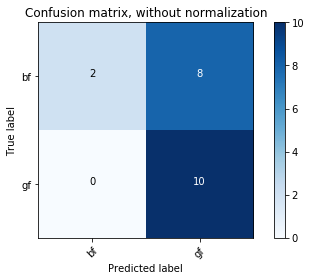

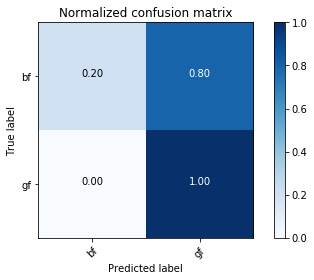

In [40]:
# Compute confusion matrix
class_names = ['bf', 'gf']
cnf_matrix = confusion_matrix(df_y['id'], df['id'])
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [26]:
Y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)